# Ultimate Inc. Data Science Challenge

### Import libraries and modify notebook settings

In [1]:
# Import libraries
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost.sklearn import XGBClassifier

# Modify notebook settings
%matplotlib inline
sns.set(style="whitegrid")
pd.options.display.max_columns = 100
pd.options.display.max_rows = 150

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Create paths to data folders and files

In [2]:
proj_root = os.path.join(os.curdir)

data_dir = os.path.join(proj_root, 'ultimate_challenge')

filepath_logins = os.path.join(data_dir, 'logins.json')

filepath_ultimate = os.path.join(data_dir,
                                 'ultimate_data_challenge.json')


### Read in raw data

In [3]:
df_logins = pd.read_json(filepath_logins)

#df_ultimate = pd.read_json(filepath_ultimate)
data_ultimate = open(filepath_ultimate, 'r').readline()
data_ultimate = json.loads(data_ultimate)
df_ultimate = pd.DataFrame(data_ultimate)

### Part 1 ‐ Exploratory data analysis

The attached `logins.json` file contains (simulated) timestamps of user logins in a particular geographic location. 

Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. 

Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [4]:
df_logins.shape

(93142, 1)

In [5]:
df_logins.head(3)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37


Are there any null values?

In [6]:
df_logins.isnull().sum()

login_time    0
dtype: int64

No, the series does not contain any null values.

Is the series in chronological order?

In [7]:
df_logins.equals(df_logins.sort_values('login_time'))

False

No.  We will sort the series so that it is in chronological order.

In [8]:
df_logins.sort_values('login_time', inplace=True)

#### Aggregate these login counts based on 15-minute time intervals,

In [9]:
df_grouped_logins = (df_logins.groupby(pd.Grouper(key='login_time',
                                                  freq='15Min'))\
                     ['login_time'].count())

df_grouped_logins = df_grouped_logins.to_frame()

df_grouped_logins.rename(columns={'login_time': 'Login Count'},
                         inplace=True)

df_grouped_logins.index.name = 'Login Bin (15 Minutes)'

Visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. 

In [10]:
one_day = int((24 * 60) / 15)
one_week = 7 * one_day

In [11]:
print('one_day:   {}  periods'.format(one_day))
print('one_week:  {} periods'.format(one_week))

one_day:   96  periods
one_week:  672 periods


In [12]:
df_grouped_logins['Login Count MA (1 Day)'] = \
df_grouped_logins.rolling(window=one_day)['Login Count'].mean()

df_grouped_logins['Login Count MA (1 Week)'] = \
df_grouped_logins.rolling(window=one_week)['Login Count'].mean()

Plot figure login counts

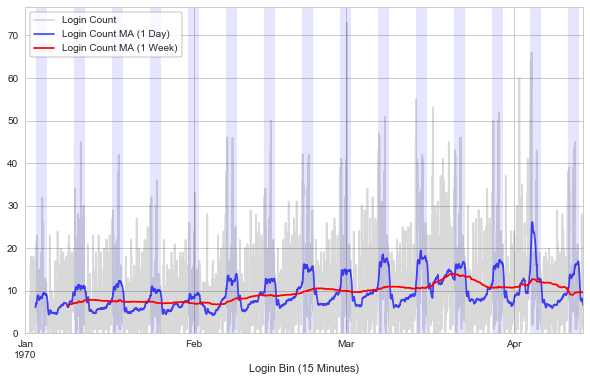

In [13]:
fig, ax = plt.subplots()

df_grouped_logins['Login Count'].\
plot(figsize=(10, 6), color='k', alpha=0.15, ax=ax)

df_grouped_logins['Login Count MA (1 Day)'].\
plot(figsize=(10, 6), color='b', alpha=0.7, ax=ax)

df_grouped_logins['Login Count MA (1 Week)'].\
plot(figsize=(10, 6), color='r', alpha=1, ax=ax)

ax.set_ylim(bottom=0)
ax.set_xlim(left=pd.Timestamp(df_grouped_logins.index[0].date()))

# Highlight weekends
weekends = df_grouped_logins[df_grouped_logins.\
                             index.dayofweek >= 5].index

delta = df_grouped_logins.index[1] - df_grouped_logins.index[0]

for i in range(len(weekends)-1):
     ax.axvspan(weekends[i], weekends[i] + delta, 
                facecolor='blue', edgecolor='none', alpha=.1)

legend = ax.legend(loc='upper left', frameon=True)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('k')

# Save the figure
plt.savefig('login_counts_time_series', dpi = 300,
            bbox_inches='tight')

Create boxplot of daily login counts

In [14]:
df_grouped_logins_1D = (df_logins.groupby(pd.Grouper(key='login_time',
                                                     freq='1D'))\
                        ['login_time'].count())

df_grouped_logins_1D = df_grouped_logins_1D.to_frame()

df_grouped_logins_1D.rename(columns={'login_time': 'Login Count (Daily)'},
                         inplace=True)

df_grouped_logins_1D.index.name = 'Login Bin (1 Day)'

df_grouped_logins_1D['Day'] = (df_grouped_logins_1D.index.weekday_name)

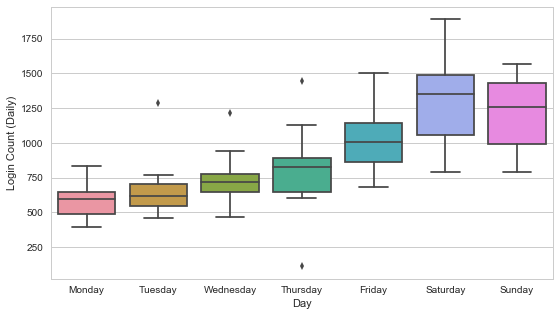

In [15]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(figsize=(9, 5))

sns.boxplot(x='Day', y='Login Count (Daily)',
            data=df_grouped_logins_1D, order=weekday_order, ax=ax)

# Save the figure
plt.savefig('login_counts_box_plot', dpi = 300, bbox_inches='tight')

# ...

###  Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


# ...

In [16]:
df_ultimate.shape

(50000, 12)

In [17]:
df_ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4
